# Circular Regression

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.lines import Line2D
from scipy import stats

In [2]:
az.style.use("arviz-white")

Directional statistics, also known as circular statistics or spherical statistics, refers to a branch of statistics dealing with data which domain is the unit circle,  as opposed to "linear" data which support is the real line. Circular data is convenient when dealing with directions or rotations. Some examples include temporal periods like hours or days, compass directions, dihedral angles in biomolecules, etc.

The fact that a Sunday can be both the day before or after a Monday, or that 0 is a "better average" for 2 and 358 degrees than 180 are illustrations that circular data and circular statistical methods are better equipped to deal with this kind of problem than the more familiar methods [1](https://en.wikipedia.org/wiki/Directional_statistics).

There are a few circular distributions, one of them is the [VonMises distribution](https://en.wikipedia.org/wiki/Von_Mises_distribution), that we can think as the cousin of the Gaussian that lives in circular space. The domain of this distribution is any interval of length $2\pi$. We are going to adopt the convention that the interval goes from $-\pi$ to $\pi$, so for example 0 radians is the same as $2\pi$. The VonMises is defined using two parameters, the mean $\mu$ (the circular mean) and the concentration $\kappa$, with $\frac{1}{\kappa}$ being analogue of the variance. Let see a few example of the VonMises family:

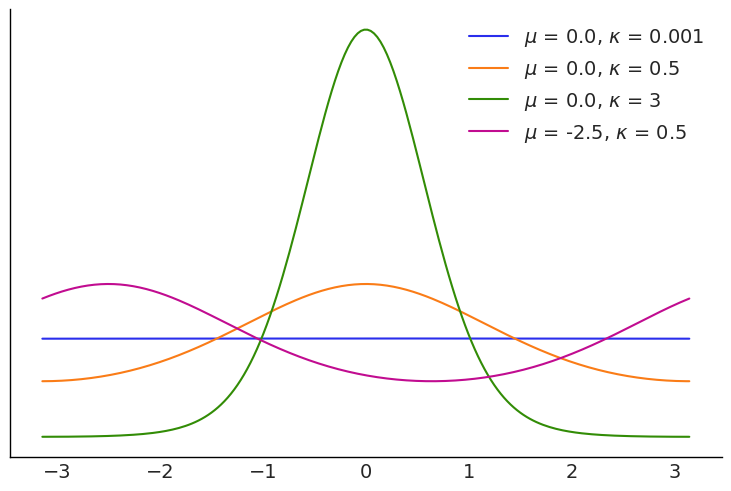

In [3]:
x = np.linspace(-np.pi, np.pi, 200)
mus = [0., 0., 0.,  -2.5]
kappas = [.001, 0.5,  3, 0.5]
for mu, kappa in zip(mus, kappas):
    pdf = stats.vonmises.pdf(x, kappa, loc=mu)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))
plt.yticks([])
plt.legend(loc=1);

When doing linear regression a commonly used link function is $2 \arctan(u)$ this ensure that values over the real line are mapped into the interval $[-\pi, \pi]$

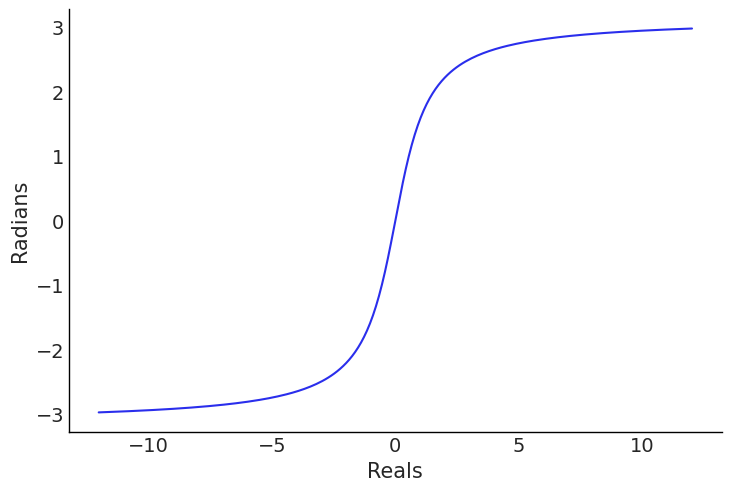

In [4]:
u = np.linspace(-12, 12, 200)
plt.plot(u, 2*np.arctan(u))
plt.xlabel("Reals")
plt.ylabel("Radians");

Bambi supports circular regression with the VonMises family, to exemplify this we are going to use a dataset from the following experiment. 31 periwinkles (a kind of sea snail) were removed from it original place and released down shore. Then, our task is to model the direction of motion as function of the distance travelled by them after being release.

In [5]:
data = bmb.load_data("periwinkles")
data.head()

,distance,direction
0,107,1.169371
1,46,1.151917
2,33,1.291544
3,67,1.064651
4,122,1.012291


Just to compare results, we are going to use the VonMises family and the normal (default) family.

In [6]:
model_vm = bmb.Model("direction ~ distance", data, family="vonmises")
idata_vm = model_vm.fit(include_mean=True)

model_n = bmb.Model("direction ~ distance", data)
idata_n = model_n.fit(include_mean=True)

/home/tomas/anaconda3/envs/bambi-dev/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op i1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/tomas/anaconda3/envs/bambi-dev/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op i0 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/tomas/anaconda3/envs/bambi-dev/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op i0 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/tomas/anaconda3/envs/bambi-dev/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Opti

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, distance]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
az.summary(idata_vm, var_names=["~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.682,0.331,1.079,2.264,0.011,0.008,1058.0,778.0,1.0
distance,-0.010,0.005,-0.018,-0.002,0.000,0.000,1205.0,892.0,1.0
kappa,2.594,0.577,1.492,3.623,0.015,0.011,1398.0,1398.0,1.0


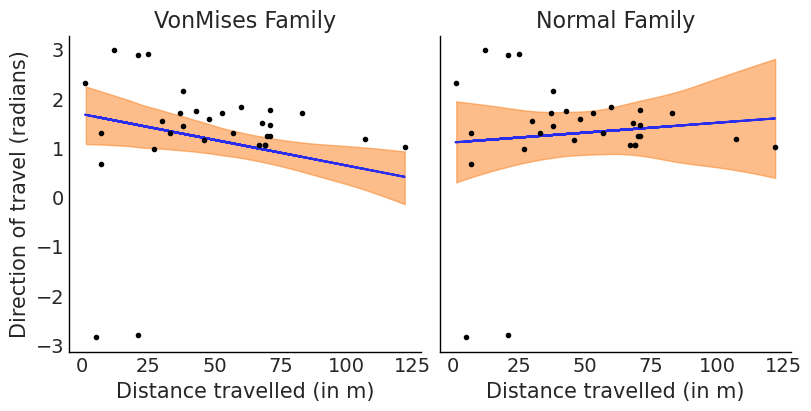

In [8]:
_, ax = plt.subplots(1,2, figsize=(8, 4), sharey=True)
posterior_mean = bmb.families.link.tan_2(idata_vm.posterior["mu"])
ax[0].plot(data.distance, posterior_mean.mean(("chain", "draw")))
az.plot_hdi(data.distance, posterior_mean, ax=ax[0])

ax[0].plot(data.distance, data.direction, "k.")
ax[0].set_xlabel("Distance travelled (in m)")
ax[0].set_ylabel("Direction of travel (radians)")
ax[0].set_title("VonMises Family")

posterior_mean = idata_n.posterior["mu"]
ax[1].plot(data.distance, posterior_mean.mean(("chain", "draw")))
az.plot_hdi(data.distance, posterior_mean, ax=ax[1])

ax[1].plot(data.distance, data.direction, "k.")
ax[1].set_xlabel("Distance travelled (in m)")
ax[1].set_title("Normal Family");

We can see that there is a negative relationship between distance and direction. This could be explained as Periwinkles travelling in a direction towards the sea travelled shorter distances than those travelling in directions away from it. From a biological perspective, this could have been due to a propensity of the periwinkles to stop moving once they are close to the sea.

We can also see that if inadvertently we had assumed a normal response we would have obtained a fit with higher uncertainty and more importantly the wrong sign for the relationship.

As a last step for this example we are going to do a posterior predictive check. In the figure below we have to panels showing the same data, with the only difference that the on the right is using a polar projection and the KDE are computing taking into account the circularity of the data.

We can see that our modeling is failing at capturing the bimodality in the data (with mode around 1.6 and $\pm \pi$) and hence the predicted distribution is wider and with a mean closer to $\pm \pi$.

/tmp/ipykernel_93347/706974292.py:6: FutureWarning: extract_dataset has been deprecated, please use extract
  pp_samples = az.extract_dataset(idata_vm, group="posterior_predictive", num_samples=200)["direction"]


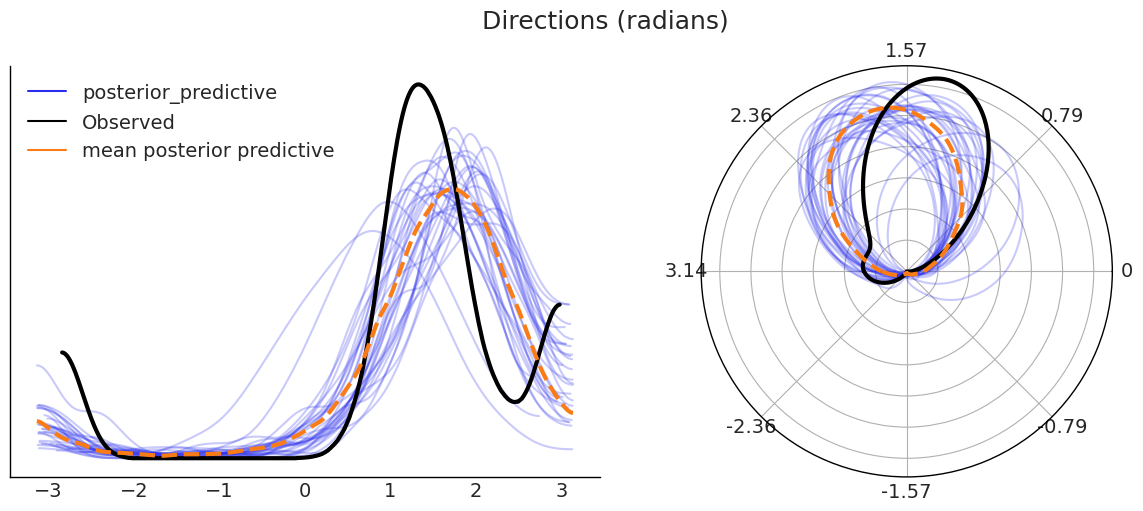

In [9]:
fig = plt.figure(figsize=(12, 5))
ax0 = plt.subplot(121)
ax1 = plt.subplot(122, projection="polar")

model_vm.predict(idata_vm, kind="response")
pp_samples = az.extract_dataset(idata_vm, group="posterior_predictive", num_samples=200)["direction"]
colors = ["C0" , "k", "C1"]

for ax, circ in zip((ax0, ax1), (False, "radians", colors)):
    for s in pp_samples:
        az.plot_kde(s.values,  plot_kwargs={"color":colors[0], "alpha": 0.25}, is_circular=circ, ax=ax)
    az.plot_kde(idata_vm.observed_data["direction"].values,
                plot_kwargs={"color":colors[1], "lw":3}, is_circular=circ, ax=ax)
    az.plot_kde(idata_vm.posterior_predictive["direction"].values,
                plot_kwargs={"color":colors[2], "ls":"--", "lw":3}, is_circular=circ, ax=ax)

custom_lines = [Line2D([0], [0], color=c) for c in colors]

ax0.legend(custom_lines, ["posterior_predictive", "Observed", 'mean posterior predictive'])
ax0.set_yticks([])
fig.suptitle("Directions (radians)", fontsize=18);

We have shown an example of regression where the response variable is circular and the covariates are linear. This is sometimes refereed as linear-circular regression in order to distinguish it from other cases. Namely, when the response is linear and the covariates (or at least one of them) is circular the name circular-linear regression is often used. And when both covariates and the response variables are circular, we have a circular-circular regression. When the covariates are circular they are usually modelled with the help of sin and cosine functions. You can read more about this kind of regression and other circular statistical methods in the following books.


* [Circular statistics in R](https://global.oup.com/academic/product/circular-statistics-in-r-9780199671137)
* [Modern directional statistics](https://www.routledge.com/Modern-Directional-Statistics/Ley-Verdebout/p/book/9780367573010)
* [Applied Directional Statistics ](https://www.routledge.com/Applied-Directional-Statistics-Modern-Methods-and-Case-Studies/Ley-Verdebout/p/book/9780367733452)
* [Directional Statistics](https://www.wiley.com/en-us/Directional+Statistics-p-9780471953333)

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat May 25 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.24.0

numpy     : 1.26.4
bambi     : 0.13.1.dev37+g2a54df76.d20240525
pandas    : 2.2.2
matplotlib: 3.8.4
arviz     : 0.18.0
scipy     : 1.13.1

Watermark: 2.4.3

